In [757]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import usefulFunctions as useful
import eval_functions as metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# Loading data
file_name = "Master_PL.xlsx - Master_PL.csv"
data = pd.read_csv(file_name, header=0, 
                    names=["id", "type", "gender", "age", "monthsFromScreening", "protein_BL", "protein_V4",
                          "protein_V6", "protein_V8", "protein_V10", "protein_V12"])

In [106]:
data.head()

,id,type,gender,age,monthsFromScreening,protein_BL,protein_V4,protein_V6,protein_V8,protein_V10,protein_V12
0,3011,1,2,32,NaN,26.0,NaN,NaN,NaN,NaN,NaN
1,3016,1,2,58,NaN,66.0,67.0,70.0,56.0,NaN,NaN
2,3069,1,1,54,NaN,24.0,34.0,32.0,30.0,33.0,NaN
3,3072,1,1,47,NaN,44.0,55.0,37.0,NaN,40.0,37.0
4,3073,1,2,48,NaN,68.0,64.0,77.0,NaN,65.0,79.0


In [107]:
def make_binary(x):
    return x-1

def make_boolean(x):
    if x:
        return bool(x)
    else:
        return bool(x)

def standardize(x, mean, std):
    return (x - mean)/std

def support(column):
    counts = defaultdict(int)
    
    for value in column:
        counts[value]+=1
    
    for key in counts:
        counts[key] = counts[key]/float(len(column))
    
    return counts

In [108]:
# Type and gender should be binary (0,1) not (1,2)
data.type = data.type.apply(make_binary)
data.gender = data.gender.apply(make_binary)

In [109]:
# Keeping all rows without fat-finger errors
data = data[(data.protein_BL > 5) & 
            (data.protein_V4 > 5) & 
            (data.protein_V6 > 5) & 
            (data.protein_V8 > 5) &
            ((data.protein_V10 > 5) | data.protein_V10.isnull()) &
            ((data.protein_V12 > 5) | data.protein_V12.isnull())].reset_index(drop=True)

In [110]:
data.head()

,id,type,gender,age,monthsFromScreening,protein_BL,protein_V4,protein_V6,protein_V8,protein_V10,protein_V12
0,3016,0,1,58,NaN,66.0,67.0,70.0,56.0,NaN,NaN
1,3069,0,0,54,NaN,24.0,34.0,32.0,30.0,33.0,NaN
2,3074,0,1,31,NaN,40.0,42.0,43.0,44.0,43.0,NaN
3,3085,0,1,57,NaN,55.0,52.0,48.0,57.0,NaN,NaN
4,3109,0,1,53,NaN,37.0,52.0,41.0,48.0,41.0,NaN


In [111]:
# After the fat finger rows I removed, we are left with 269 patients
len(data)

269

In [112]:
# normalizing all real values, the Random Forest Classifier preforms better after doing this
# I suspect this is due to sklearn's implementation and not the theory behind 
# Forest Classifiers
bl_mean = np.nanmean(data.protein_BL)
bl_std = np.nanstd(data.protein_BL)

v4_mean = np.nanmean(data.protein_V4)
v4_std = np.nanstd(data.protein_V4)

v6_mean = np.nanmean(data.protein_V6)
v6_std = np.nanstd(data.protein_V6)

v8_mean = np.nanmean(data.protein_V8)
v8_std = np.nanstd(data.protein_V8)

v10_mean = np.nanmean(data.protein_V10)
v10_std = np.nanstd(data.protein_V10)

v12_mean = np.nanmean(data.protein_V12)
v12_std = np.nanstd(data.protein_V12)

age_mean = np.nanmean(data.age)
age_std = np.nanstd(data.age)

data.protein_BL = data.protein_BL.apply(lambda x : standardize(x, bl_mean, bl_std))
data.protein_V4 = data.protein_V4.apply(lambda x : standardize(x, v4_mean, v4_std))
data.protein_V6 = data.protein_V6.apply(lambda x : standardize(x, v6_mean, v6_std))
data.protein_V8 = data.protein_V8.apply(lambda x : standardize(x, v8_mean, v8_std))
data.protein_V10 = data.protein_V10.apply(lambda x : standardize(x, v10_mean, v10_std))
data.protein_V12 = data.protein_V12.apply(lambda x : standardize(x, v12_mean, v12_std))
data.age = data.age.apply(lambda x: standardize(x, age_mean, age_std))

In [113]:
data.head()

,id,type,gender,age,monthsFromScreening,protein_BL,protein_V4,protein_V6,protein_V8,protein_V10,protein_V12
0,3016,0,1,-0.305631,NaN,1.293955,0.744712,0.708462,0.615134,NaN,NaN
1,3069,0,0,-0.700893,NaN,-1.148138,-0.433034,-0.395604,-0.754484,-0.675079,NaN
2,3074,0,1,-2.973653,NaN,-0.217817,-0.147520,-0.076006,-0.016998,-0.130630,NaN
3,3085,0,1,-0.404446,NaN,0.654359,0.209373,0.069266,0.667811,NaN,NaN
4,3109,0,1,-0.799709,NaN,-0.392252,0.209373,-0.134115,0.193713,-0.239520,NaN


In [114]:
# Fixing the type imbalance
# We should be more focused on Class 1 performance in the classification task, due to us
# upsampling Class 0.
# The nature of learning/classifcation for Random Forests is particularly susceptible to 
# inflating perfmance when upsampling
# Measures have been put in place to curb this problem (min_samples_per_leaf)

df_majority = data[data.type==1]
print(len(df_majority))
df_minority = data[data.type==0]
print(len(df_minority))
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=123)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.type.value_counts()

188
81


1    188
0    188
Name: type, dtype: int64

In [746]:
# Removing V_10, V_12 due to lack of data
# Removing type (as that is the label)
features = df_upsampled[['age', 
                  'gender', 
                  'protein_BL', 
                  'protein_V4', 
                  'protein_V6', 
                  'protein_V8']]

# for analysis purposes I used different combincations of the features below
features_to_keep = [
                  'age', 
                  'gender', 
                  'protein_BL', 
                  'protein_V4', 
                  'protein_V6', 
                  'protein_V8'
                ]

X = []
for i, row in features.iterrows():
    filterd_vec = []
    for key in features_to_keep:
        filterd_vec.append(row[key])
    X.append(filterd_vec)


y = df_upsampled[['type']].as_matrix()
y = np.squeeze(labels)

13.16

In [749]:
# Due to upsampling we take 20 different random splits of the data and take
# the average performance as the true classification performance
def test_clf_performance(X, y):
    y_true_array = []
    y_predicted_array = []
    feature_importances_array = []
    for i in range(20):

        # creating the test/train splits
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i*i)

        # creating the classifier,
        clf = RandomForestClassifier(n_estimators = 50, min_samples_split = 10, random_state = 42)

        # fitting the classifier to the data
        classifier.fit(np.array(X_train), y_train)

        # storing the true labels
        y_true_array.append(y_test)

        # storing the predicted labels
        y_predicted_array.append(classifier.predict(X_test))

        # storing feature importance
        feature_importances_array.append(classifier.feature_importances_)

    all_metrics = metrics.average_all_metrics(y_true_array, y_predicted_array, 2)
    print(metrics.pretty_print_metrics(all_metrics))
    print(metrics.average_feature_importances(feature_importances_array))
    return all_metrics

In [750]:
all_metrics = test_clf_performance(X, y)

iterations: 20

accuracy: 0.656

precision: 
	micro: 0.656
	all: ['0.677', '0.649']
	weighted: 0.667
	macro: 0.663
	
recall: 
	micro: 0.656
	all: ['0.644', '0.678']
	weighted: 0.656
	macro: 0.661
	
f1_measure: 
	micro: 0.656
	all: ['0.654', '0.656']
	weighted: 0.655
	macro: 0.655
	
support: 
	y_true_count: 113.000
	y_predicted_dist: ['0.488', '0.512']
	y_true_dist: ['0.511', '0.489']
	y_predicted_count: 113.000
	

[0.35113591093208485, 0.31029769759834058, 0.33856639146957468]


In [751]:
# Finding a split that mimics the average performance of the classification task
clf = RandomForestClassifier(n_estimators = 50, min_samples_split = 10, random_state = 42)
good_random_state = 0
while good_random_state < 1000:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = good_random_state)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    predicted_labels = []
    for prob_tuple in probs:
        if prob_tuple[1] > 0.5:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    official_metrics = metrics.get_all_metrics(y_test, predicted_labels)
    if abs(official_metrics["precision"]["all"][1] - all_metrics["precision"]["all"][1]) < 0.0175:
        if abs(official_metrics["recall"]["all"][1] - all_metrics["recall"]["all"][1]) < 0.0175:
            if abs(official_metrics["precision"]["all"][0] - all_metrics["precision"]["all"][0]) < 0.0175:
                if abs(official_metrics["recall"]["all"][0] - all_metrics["recall"]["all"][0]) < 0.0175:
                    print(metrics.pretty_print_metrics(official_metrics))
                    print("random-state: " + str(good_random_state))
                    break
    if good_random_state % 100 == 0:
        print("100 more done")
    good_random_state += 1

100 more done
100 more done
1

accuracy: 0.655

precision: 
	all: ['0.667', '0.644']
	micro: 0.655
	macro: 0.655
	weighted: 0.655
	
recall: 
	all: ['0.632', '0.679']
	micro: 0.655
	macro: 0.655
	weighted: 0.655
	
f1_measure: 
	all: ['0.649', '0.661']
	micro: 0.655
	macro: 0.655
	weighted: 0.655
	
support: 
	y_true_dist: ['0.504', '0.496']
	y_true_count: 113.000
	y_predicted_dist: ['0.478', '0.522']
	y_predicted_count: 113.000
	

random-state: 101


In [752]:
clf = RandomForestClassifier(n_estimators = 50, 
                             min_samples_split = 10, 
                             random_state = 42)

In [753]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = good_random_state)

In [754]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [755]:
probs = clf.predict_proba(X_test)
affected_probs = [x[1] for x in probs]

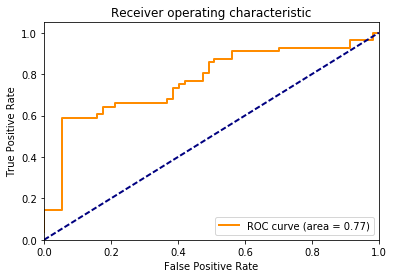

In [756]:
# Plotting AUC curve for "average" classifier
metrics.plot_roc_curve(y_test, affected_probs)

In [447]:
[estimator.tree_.max_depth for estimator in clf.estimators_]

[9,
 18,
 12,
 15,
 9,
 8,
 14,
 13,
 12,
 8,
 12,
 14,
 8,
 18,
 10,
 11,
 10,
 11,
 15,
 10,
 14,
 11,
 14,
 10,
 10,
 11,
 10,
 11,
 12,
 10,
 15,
 14,
 11,
 16,
 13,
 12,
 12,
 11,
 11,
 13,
 12,
 10,
 12,
 12,
 10,
 8,
 12,
 9,
 14,
 10]